In [1]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [2]:
"""
Base class template for Collection transformers.

    class name: BaseCollectionTransformer

Defining methods:
    fitting         - fit(self, X, y=None)
    transform       - transform(self, X, y=None)
    fit&transform   - fit_transform(self, X, y=None)
    updating        - update(self, X, y=None)

Inherited inspection methods:
    hyper-parameter inspection  - get_params()
    fitted parameter inspection - get_fitted_params()

State:
    fitted model/strategy   - by convention, any attributes ending in "_"
    fitted state flag       - is_fitted (property)
    fitted state inspection - check_is_fitted()
"""

__maintainer__ = []
__all__ = [
    "BaseCollectionTransformer",
]

from abc import abstractmethod
from typing import final

import numpy as np
import pandas as pd

from aeon.base import BaseCollectionEstimator
from aeon.transformations.base import BaseTransformer


class BaseCollectionTransformer(BaseCollectionEstimator, BaseTransformer):
    """Transformer base class for collections."""

    # tag values specific to CollectionTransformers
    _tags = {
        "input_data_type": "Collection",
        "output_data_type": "Collection",
        "removes_unequal_length": False,
    }

    @abstractmethod
    def __init__(self):
        super().__init__()

    @final
    def fit(self, X, y=None):
        """Fit transformer to X, optionally using y if supervised.

        State change:
            Changes state to "fitted".

        Writes to self:
        _is_fitted : flag is set to True.
        model attributes (ending in "_") : dependent on estimator

        Parameters
        ----------
        X : np.ndarray or list
            Input data, any number of channels, equal length series of shape ``(
            n_cases, n_channels, n_timepoints)``
            or list of numpy arrays (any number of channels, unequal length series)
            of shape ``[n_cases]``, 2D np.array ``(n_channels, n_timepoints_i)``,
            where ``n_timepoints_i`` is length of series ``i``. Other types are
            allowed and converted into one of the above.

            Different estimators have different capabilities to handle different
            types of input. If `self.get_tag("capability:multivariate")`` is False,
            they cannot handle multivariate series. If ``self.get_tag(
            "capability:unequal_length")`` is False, they cannot handle unequal
            length input. In both situations, a ``ValueError`` is raised if X has a
            characteristic that the estimator does not have the capability to handle.
              Data to fit transform to, of valid collection type.
        y : np.ndarray, default=None
            1D np.array of float or str, of shape ``(n_cases)`` - class labels
            (ground truth) for fitting indices corresponding to instance indices in X.
            If None, no labels are used in fitting.

        Returns
        -------
        self : a fitted instance of the estimator
        """
        if self.get_tag("requires_y"):
            if y is None:
                raise ValueError("Tag requires_y is true, but fit called with y=None")
        # skip the rest if fit_is_empty is True
        if self.get_tag("fit_is_empty"):
            self.is_fitted = True
            return self
        self.reset()

        # input checks and datatype conversion
        X_inner = self._preprocess_collection(X)
        y_inner = y
        self._fit(X=X_inner, y=y_inner)

        self.is_fitted = True

        return self

    @final
    def transform(self, X, y=None):
        """Transform X and return a transformed version.

        State required:
            Requires state to be "fitted".

        Accesses in self:
        _is_fitted : must be True
        fitted model attributes (ending in "_") : must be set, accessed by _transform

        Parameters
        ----------
        X : np.ndarray or list
            Input data, any number of channels, equal length series of shape ``(
            n_cases, n_channels, n_timepoints)``
            or list of numpy arrays (any number of channels, unequal length series)
            of shape ``[n_cases]``, 2D np.array ``(n_channels, n_timepoints_i)``,
            where ``n_timepoints_i`` is length of series ``i``. Other types are
            allowed and converted into one of the above.

            Different estimators have different capabilities to handle different
            types of input. If `self.get_tag("capability:multivariate")`` is False,
            they cannot handle multivariate series. If ``self.get_tag(
            "capability:unequal_length")`` is False, they cannot handle unequal
            length input. In both situations, a ``ValueError`` is raised if X has a
            characteristic that the estimator does not have the capability to handle.
              Data to fit transform to, of valid collection type.
        y : np.ndarray, default=None
            1D np.array of float or str, of shape ``(n_cases)`` - class labels
            (ground truth) for fitting indices corresponding to instance indices in X.
            If None, no labels are used in fitting.

        Returns
        -------
        transformed version of X
        """
        # check whether is fitted
        self._check_is_fitted()

        # input check and conversion for X/y
        X_inner = self._preprocess_collection(X, store_metadata=False)
        y_inner = y

        if not self.get_tag("fit_is_empty"):
            self._check_shape(X)

        Xt = self._transform(X=X_inner, y=y_inner)

        return Xt

    @final
    def fit_transform(self, X, y=None):
        """
        Fit to data, then transform it.

        Fits the transformer to X and y and returns a transformed version of X.

        State change:
            Changes state to "fitted".

        Writes to self:
        _is_fitted : flag is set to True.
        model attributes (ending in "_") : dependent on estimator.

        Parameters
        ----------
        X : np.ndarray or list
            Input data, any number of channels, equal length series of shape ``(
            n_cases, n_channels, n_timepoints)``
            or list of numpy arrays (any number of channels, unequal length series)
            of shape ``[n_cases]``, 2D np.array ``(n_channels, n_timepoints_i)``,
            where ``n_timepoints_i`` is length of series ``i``. Other types are
            allowed and converted into one of the above.

            Different estimators have different capabilities to handle different
            types of input. If `self.get_tag("capability:multivariate")`` is False,
            they cannot handle multivariate series. If ``self.get_tag(
            "capability:unequal_length")`` is False, they cannot handle unequal
            length input. In both situations, a ``ValueError`` is raised if X has a
            characteristic that the estimator does not have the capability to handle.
              Data to fit transform to, of valid collection type.
        y : np.ndarray, default=None
            1D np.array of float or str, of shape ``(n_cases)`` - class labels
            (ground truth) for fitting indices corresponding to instance indices in X.
            If None, no labels are used in fitting.

        Returns
        -------
        transformed version of X
        """
        # input checks and datatype conversion
        self.reset()
        X_inner = self._preprocess_collection(X)
        y_inner = y
        Xt = self._fit_transform(X=X_inner, y=y_inner)

        self.is_fitted = True

        return Xt

    @final
    def inverse_transform(self, X, y=None):
        """Inverse transform X and return an inverse transformed version.

        Currently it is assumed that only transformers with tags
             "input_data_type"="Series", "output_data_type"="Series",
        can have an inverse_transform.

        State required:
             Requires state to be "fitted".

        Accesses in self:
         _is_fitted : must be True
         fitted model attributes (ending in "_") : accessed by _inverse_transform

        Parameters
        ----------
        X : np.ndarray or list
            Input data, any number of channels, equal length series of shape ``(
            n_cases, n_channels, n_timepoints)``
            or list of numpy arrays (any number of channels, unequal length series)
            of shape ``[n_cases]``, 2D np.array ``(n_channels, n_timepoints_i)``,
            where ``n_timepoints_i`` is length of series ``i``. Other types are
            allowed and converted into one of the above.

            Different estimators have different capabilities to handle different
            types of input. If `self.get_tag("capability:multivariate")`` is False,
            they cannot handle multivariate series. If ``self.get_tag(
            "capability:unequal_length")`` is False, they cannot handle unequal
            length input. In both situations, a ``ValueError`` is raised if X has a
            characteristic that the estimator does not have the capability to handle.
              Data to fit transform to, of valid collection type.
        y : np.ndarray, default=None
            1D np.array of float or str, of shape ``(n_cases)`` - class labels
            (ground truth) for fitting indices corresponding to instance indices in X.
            If None, no labels are used in fitting.

        Returns
        -------
        inverse transformed version of X
            of the same type as X
        """
        if not self.get_tag("capability:inverse_transform"):
            raise NotImplementedError(
                f"{type(self)} does not implement inverse_transform"
            )

        # check whether is fitted
        self._check_is_fitted()

        # input check and conversion for X/y
        X_inner = self._preprocess_collection(X, store_metadata=False)
        y_inner = y

        Xt = self._inverse_transform(X=X_inner, y=y_inner)

        return Xt

    def _fit(self, X, y=None):
        """Fit transformer to X and y.

        private _fit containing the core logic, called from fit

        Parameters
        ----------
        X : Input data
            Data to fit transform to, of valid collection type.
        y : Target variable, default=None
            Additional data, e.g., labels for transformation

        Returns
        -------
        self: a fitted instance of the estimator

        See extension_templates/transformer.py for implementation details.
        """
        # default fit is "no fitting happens"
        return self

    @abstractmethod
    def _transform(self, X, y=None):
        """Transform X and return a transformed version.

        private _transform containing the core logic, called from transform

        Parameters
        ----------
        X : Input data
            Data to fit transform to, of valid collection type.
        y : Target variable, default=None
            Additional data, e.g., labels for transformation

        Returns
        -------
        transformed version of X
        """

    def _fit_transform(self, X, y=None):
        """Fit to data, then transform it.

        Fits the transformer to X and y and returns a transformed version of X.

        private _fit_transform containing the core logic, called from fit_transform.

        Parameters
        ----------
        X : Input data
            Data to fit transform to, of valid collection type.
        y : Target variable, default=None
            Additional data, e.g., labels for transformation.

        Returns
        -------
        transformed version of X.
        """
        # Non-optimized default implementation; override when a better
        # method is possible for a given algorithm.
        self._fit(X, y)
        return self._transform(X, y)

    def _inverse_transform(self, X, y=None):
        """Inverse transform X and return an inverse transformed version.

        private _inverse_transform containing core logic, called from inverse_transform.

        Parameters
        ----------
        X : Input data
            Data to fit transform to, of valid collection type.
        y : Target variable, default=None
            Additional data, e.g., labels for transformation

        Returns
        -------
        inverse transformed version of X
            of the same type as X.
        """
        raise NotImplementedError(
            f"{self.__class__.__name__} does not support inverse_transform"
        )

    def _update(self, X, y=None):
        """Update transformer with X and y.

        private _update containing the core logic, called from update

        Parameters
        ----------
        X : Input data
            Data to fit transform to, of valid collection type.
        y : Target variable, default=None
            Additional data, e.g., labels for transformation

        Returns
        -------
        self: a fitted instance of the estimator.
        """
        # standard behaviour: no update takes place, new data is ignored
        return self


def _check_y(self, y, n_cases):
    if y is None:
        return None
    # Check y valid input for collection transformations
    if not isinstance(y, (pd.Series, np.ndarray)):
        raise TypeError(
            f"y must be a np.array or a pd.Series, but found type: {type(y)}"
        )
    if isinstance(y, np.ndarray) and y.ndim > 1:
        raise TypeError(f"y must be 1-dimensional, found {y.ndim} dimensions")
    # Check matching number of labels
    n_labels = y.shape[0]
    if n_cases != n_labels:
        raise ValueError(
            f"Mismatch in number of cases. Number in X = {n_cases} nos in y = "
            f"{n_labels}"
        )

In [3]:
"""Random Dilated Shapelet Transform (RDST) Classifier.

A Random Dilated Shapelet Transform classifier pipeline that simply performs a random
shapelet dilated transform and builds (by default) a ridge classifier on the output.
"""

__maintainer__ = ["baraline"]
__all__ = ["RDSTClassifier"]

from typing import Union

import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from typing import Union, List, Dict
from aeon.base._base import _clone_estimator
from aeon.classification.base import BaseClassifier
from aeon.transformations.collection.shapelet_based import (
    RandomDilatedShapeletTransform,
)


class RDSTClassifier(BaseClassifier):
    """
    A random dilated shapelet transform (RDST) classifier.

    Implementation of the random dilated shapelet transform classifier pipeline
    along the lines of [1]_, [2]_. Transforms the data using the
    `RandomDilatedShapeletTransform` and then builds a `RidgeClassifierCV` classifier
    with standard scaling.

    Parameters
    ----------
    max_shapelets : int, default=10000
        The maximum number of shapelets to keep for the final transformation.
        A lower number of shapelets can be kept if alpha similarity has discarded the
        whole dataset.
    shapelet_lengths : array, default=None
        The set of possible lengths for shapelets. Each shapelet length is uniformly
        drawn from this set. If None, the shapelet length will be equal to
        min(max(2,n_timepoints//2),11).
    proba_normalization : float, default=0.8
        This probability (between 0 and 1) indicates the chance of each shapelet to be
        initialized such as it will use a z-normalized distance, inducing either scale
        sensitivity or invariance. A value of 1 would mean that all shapelets will use
        a z-normalized distance.
    threshold_percentiles : array, default=None
        The two perceniles used to select the threshold used to compute the Shapelet
        Occurrence feature. If None, the 5th and the 10th percentiles (i.e. [5,10])
        will be used.
    alpha_similarity : float, default=0.5
        The strength of the alpha similarity pruning. The higher the value, the fewer
        common indexes with previously sampled shapelets are allowed when sampling a
        new candidate with the same dilation parameter. It can cause the number of
        sampled shapelets to be lower than max_shapelets if the whole search space has
        been covered. The default is 0.5, and the maximum is 1. Values above it have
        no effect for now.
    use_prime_dilations : bool, default=False
        If True, restricts the value of the shapelet dilation parameter to be prime
        values. This can greatly speed-up the algorithm for long time series and/or
        short shapelet lengths, possibly at the cost of some accuracy.
    estimator : BaseEstimator or None, default=None
        Base estimator for the ensemble, can be supplied a sklearn `BaseEstimator`. If
        `None` a default `RidgeClassifierCV` classifier is used with standard scaling.
    save_transformed_data : bool, default=False
        If True, the transformed training dataset for all classifiers will be saved.
    class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Only applies if estimator is None, and the default is used.
        From sklearn documentation:
        If not given, all classes are supposed to have weight one.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights
        are computed based on the bootstrap sample for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both ``fit`` and ``predict``.
        `-1` means using all processors.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    Attributes
    ----------
    classes_ : list
        The unique class labels in the training set.
    n_classes_ : int
        The number of unique classes in the training set.
    transformed_data_ : list of shape (n_estimators) of ndarray
        The transformed training dataset for all classifiers. Only saved when
        ``save_transformed_data`` is `True`.

    See Also
    --------
    RandomDilatedShapeletTransform : The randomly dilated shapelet transform.
    RidgeClassifierCV : The default classifier used.

    References
    ----------
    .. [1] Antoine Guillaume et al. "Random Dilated Shapelet Transform: A New Approach
       for Time Series Shapelets", Pattern Recognition and Artificial Intelligence.
       ICPRAI 2022.
    .. [2] Antoine Guillaume, "Time series classification with shapelets: Application
       to predictive maintenance on event logs", PhD Thesis, University of Orléans,
       2023.


    Examples
    --------
    >>> from aeon.classification.shapelet_based import RDSTClassifier
    >>> from aeon.datasets import load_unit_test
    >>> X_train, y_train = load_unit_test(split="train")
    >>> X_test, y_test = load_unit_test(split="test")
    >>> clf = RDSTClassifier(
    ...     max_shapelets=10
    ... )
    >>> clf.fit(X_train, y_train)
    RDSTClassifier(...)
    >>> y_pred = clf.predict(X_test)
    """

    _tags = {
        "capability:multivariate": True,
        "capability:unequal_length": True,
        "capability:multithreading": True,
        "X_inner_type": ["np-list", "numpy3D"],
        "algorithm_type": "shapelet",
    }

    def __init__(
        self,
        max_shapelets: int = 50000,
        shapelet_lengths=None,
        proba_normalization: float = 0.8,
        threshold_percentiles=None,
        alpha_similarity: float = 0.5,
        use_prime_dilations: bool = False,
        estimator=None,
        save_transformed_data: bool = False,
        class_weight=None,
        n_jobs: int = 1,
        random_state: Union[int, np.random.RandomState, None] = None,
    ) -> None:
        self.max_shapelets = max_shapelets
        self.shapelet_lengths = shapelet_lengths
        self.proba_normalization = proba_normalization
        self.threshold_percentiles = threshold_percentiles
        self.alpha_similarity = alpha_similarity
        self.use_prime_dilations = use_prime_dilations
        self.estimator = estimator
        self.save_transformed_data = save_transformed_data
        self.class_weight = class_weight
        self.random_state = random_state
        self.n_jobs = n_jobs

        self.transformed_data_ = []

        self._transformer = None
        self._estimator = None

        super().__init__()

    def _fit(self, X, y):
        """Fit Classifier to training data.

        Parameters
        ----------
        X: np.ndarray shape (n_cases, n_channels, n_timepoints)
            The training input samples.
        y: array-like or list
            The class labels for samples in X.

        Returns
        -------
        self :
            Reference to self.

        Notes
        -----
        Changes state by creating a fitted model that updates attributes
        ending in "_".
        """
        self._transformer = RandomDilatedShapeletTransform(
            max_shapelets=self.max_shapelets,
            shapelet_lengths=self.shapelet_lengths,
            proba_normalization=self.proba_normalization,
            threshold_percentiles=self.threshold_percentiles,
            alpha_similarity=self.alpha_similarity,
            use_prime_dilations=self.use_prime_dilations,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )
        if self.estimator is None:
            self._estimator = make_pipeline(
                StandardScaler(with_mean=True),
                RidgeClassifierCV(
                    alphas=np.logspace(-4, 4, 20),
                    class_weight=self.class_weight,
                ),
            )
        else:
            self._estimator = _clone_estimator(self.estimator, self.random_state)
            m = getattr(self._estimator, "n_jobs", None)
 
            if m is not None:
                self._estimator.n_jobs = self.n_jobs

        X_t = self._transformer.fit_transform(X, y)

        if self.save_transformed_data:
            self.transformed_data_ = X_t

        self._estimator.fit(X_t, y)

        return self

    def _predict(self, X) -> np.ndarray:
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X: np.ndarray shape (n_cases, n_channels, n_timepoints)
            The data to make predictions for.

        Returns
        -------
        y : array-like, shape = [n_cases]
            Predicted class labels.
        """
        X_t = self._transformer.transform(X)

        return self._estimator.predict(X_t)

    def _predict_proba(self, X) -> np.ndarray:
        """Predicts label probabilities for sequences in X.

        Parameters
        ----------
        X: np.ndarray shape (n_cases, n_channels, n_timepoints)
            The data to predict probabilities for.

        Returns
        -------
        y : array-like, shape = [n_cases, n_classes_]
            Predicted probabilities using the ordering in classes_.
        """
        X_t = self._transformer.transform(X)

        m = getattr(self._estimator, "predict_proba", None)
        if callable(m):
            return self._estimator.predict_proba(X_t)
        else:
            dists = np.zeros((len(X), self.n_classes_))
            preds = self._estimator.predict(X_t)
            for i in range(0, len(X)):
                dists[i, np.where(self.classes_ == preds[i])] = 1
            return dists

    def _get_test_params(
        cls, parameter_set: str = "default"
    ) -> Union[Dict, List[Dict]]:
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            For classifiers, a "default" set of parameters should be provided for
            general testing, and a "results_comparison" set for comparing against
            previously recorded results if the general set does not produce suitable
            probabilities to compare against.

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
        """
        return {"max_shapelets": 20}

In [4]:
"""RandOm Convolutional KErnel Transform (Rocket).

Pipeline classifier using the ROCKET transformer and an sklearn classifier.
"""

__maintainer__ = []
__all__ = ["RocketClassifier"]

import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from aeon.transformations.collection import base
from aeon.base._base import _clone_estimator
from aeon.classification import BaseClassifier
from aeon.transformations.collection.convolution_based import (
    MiniRocket,
    MultiRocket,
    Rocket,
)


class RocketClassifier(BaseClassifier):
    """
    Classifier wrapped for the Rocket transformer using RidgeClassifierCV.

    This classifier simply transforms the input data using a Rocket [1,2,3]_
    transformer, performs a Standard scaling and fits a sklearn classifier,
    using the transformed data (default classifier is RidgeClassifierCV).

    The classifier can be configured to use Rocket [1]_, MiniRocket [2]_ or
    MultiRocket [3]_.

    Parameters
    ----------
    num_kernels : int, default=10,000
        The number of kernels for the Rocket transform.
    rocket_transform : str, default="rocket"
        The type of Rocket transformer to use.
        Valid inputs = ["rocket", "minirocket", "multirocket"].
    max_dilations_per_kernel : int, default=32
        MiniRocket and MultiRocket only. The maximum number of dilations per kernel.
    n_features_per_kernel : int, default=4
        MultiRocket only. The number of features per kernel.
    estimator : sklearn compatible classifier or None, default=None
        The estimator used. If None, a RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
        is used.
    class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Only applies if estimator is None and the default is used.
        From sklearn documentation:
        If not given, all classes are supposed to have weight one.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights
        are computed based on the bootstrap sample for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both `fit` and `predict`.
        ``-1`` means using all processors.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    Attributes
    ----------
    n_classes_ : int
        The number of classes.
    classes_ : list
        The classes labels.

    See Also
    --------
    Rocket
        Rocket transformers are in transformations/collection.
    RocketRegressor

    References
    ----------
    .. [1] Dempster, A., Petitjean, F. and Webb, G.I., 2020. ROCKET: exceptionally fast
        and accurate time series classification using random convolutional kernels.
        Data Mining and Knowledge Discovery, 34(5), pp.1454-1495.
    .. [2] Dempster, A., Schmidt, D.F. and Webb, G.I., 2021, August. Minirocket: A very
        fast (almost) deterministic transform for time series classification. In
        Proceedings of the 27th ACM SIGKDD conference on knowledge discovery & data
        mining (pp. 248-257).
    .. [3] Tan, C.W., Dempster, A., Bergmeir, C. and Webb, G.I., 2022. MultiRocket:
        multiple pooling operators and transformations for fast and effective time
        series classification. Data Mining and Knowledge Discovery, 36(5), pp.1623-1646.

    Examples
    --------
    >>> from aeon.classification.convolution_based import RocketClassifier
    >>> from aeon.datasets import load_unit_test
    >>> X_train, y_train = load_unit_test(split="train")
    >>> X_test, y_test = load_unit_test(split="test")
    >>> clf = RocketClassifier(num_kernels=500)
    >>> clf.fit(X_train, y_train)
    RocketClassifier(...)
    >>> y_pred = clf.predict(X_test)
    """

    _tags = {
        "capability:multithreading": True,
        "capability:multivariate": True,
        "algorithm_type": "convolution",
    }

    def __init__(
        self,
        num_kernels=20000,
        rocket_transform="rocket",
        max_dilations_per_kernel=32,
        n_features_per_kernel=4,
        estimator=None,
        class_weight=None,
        n_jobs=1,
        random_state=None,
    ):
        self.num_kernels = num_kernels
        self.rocket_transform = rocket_transform
        self.max_dilations_per_kernel = max_dilations_per_kernel
        self.n_features_per_kernel = n_features_per_kernel
        self.estimator = estimator

        self.class_weight = class_weight
        self.n_jobs = n_jobs
        self.random_state = random_state

        super().__init__()

    def _fit(self, X, y):
        """Fit Rocket variant to training data.

        Parameters
        ----------
        X : 3D np.ndarray
            The training data of shape = (n_cases, n_channels, n_timepoints).
        y : 3D np.ndarray
            The class labels, shape = (n_cases,).

        Returns
        -------
        self :
            Reference to self.

        Notes
        -----
        Changes state by creating a fitted model that updates attributes
        ending in "_" and sets is_fitted flag to True.
        """
        self.n_cases_, self.n_channels_, self.n_timepoints_ = X.shape

        rocket_transform = self.rocket_transform.lower()
        if rocket_transform == "rocket":
            self._transformer = Rocket(
                num_kernels=self.num_kernels,
                n_jobs=self.n_jobs,
                random_state=self.random_state,
            )
        elif rocket_transform == "minirocket":
            self._transformer = MiniRocket(
                num_kernels=self.num_kernels,
                max_dilations_per_kernel=self.max_dilations_per_kernel,
                n_jobs=self.n_jobs,
                random_state=self.random_state,
            )
        elif rocket_transform == "multirocket":
            self._transformer = MultiRocket(
                num_kernels=self.num_kernels,
                max_dilations_per_kernel=self.max_dilations_per_kernel,
                n_features_per_kernel=self.n_features_per_kernel,
                n_jobs=self.n_jobs,
                random_state=self.random_state,
            )
        else:
            raise ValueError(f"Invalid Rocket transformer: {self.rocket_transform}")

        self._scaler = StandardScaler(with_mean=False)
        self._estimator = _clone_estimator(
            (
                RidgeClassifierCV(
                    alphas=np.logspace(-3, 3, 10), class_weight=self.class_weight
                )
                if self.estimator is None
                else self.estimator
            ),
            self.random_state,
        )

        self.pipeline_ = make_pipeline(
            self._transformer,
            self._scaler,
            self._estimator,
        )
        self.pipeline_.fit(X, y)

        return self

    def _predict(self, X) -> np.ndarray:
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray of shape = (n_cases, n_channels, n_timepoints)
            The data to make predictions for.

        Returns
        -------
        y : array-like, shape = (n_cases,)
            Predicted class labels.
        """
        return self.pipeline_.predict(X)

    def _predict_proba(self, X) -> np.ndarray:
        """Predicts labels probabilities for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray of shape = (n_cases, n_channels, n_timepoints)
            The data to make predict probabilities for.

        Returns
        -------
        y : array-like, shape = (n_cases, n_classes_)
            Predicted probabilities using the ordering in classes_.
        """
        m = getattr(self._estimator, "predict_proba", None)
        if callable(m):
            return self.pipeline_.predict_proba(X)
        else:
            dists = np.zeros((X.shape[0], self.n_classes_))
            preds = self.pipeline_.predict(X)
            for i in range(0, X.shape[0]):
                dists[i, np.where(self.classes_ == preds[i])] = 1
            return dists

    @classmethod
    def get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            RocketClassifier provides the following special sets:
                 "results_comparison" - used in some classifiers to compare against
                    previously generated results where the default set of parameters
                    cannot produce suitable probability estimates

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
            `create_test_instance` uses the first (or only) dictionary in `params`.
        """
        if parameter_set == "results_comparison":
            return {"num_kernels": 100}
        else:
            return {"num_kernels": 20}

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct  # Import DCT from scipy
import librosa  # Ensure librosa is imported for loading audio files

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def pre_emphasis(signal, alpha=0.97):
    """Apply pre-emphasis filter."""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_size)) / hop_size)) + 1
    pad_signal_length = num_frames * hop_size + frame_size
    z = np.zeros(pad_signal_length)
    z[:len(signal)] = signal
    
    frames = np.lib.stride_tricks.as_strided(z,
        shape=(num_frames, frame_size),
        strides=(z.strides[0] * hop_size, z.strides[0])).copy()
    
    return frames

def hamming_window(frame):
    """Apply Hamming window to a frame."""
    return np.hamming(len(frame)) * frame

def mel_filter_bank(num_filters, fft_size, sample_rate, low_freq=0, high_freq=None):
    """Create a Mel filter bank."""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # Convert frequency to Mel scale
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(fft_size / 2 + 1))))
    
    for n in range(1, num_filters + 1):
        filters[n - 1, bin_points[n - 1]:bin_points[n]] = \
            (np.arange(bin_points[n - 1], bin_points[n]) - bin_points[n - 1]) / (bin_points[n] - bin_points[n - 1])
        filters[n - 1, bin_points[n]:bin_points[n + 1]] = \
            (bin_points[n + 1] - np.arange(bin_points[n], bin_points[n + 1])) / (bin_points[n + 1] - bin_points[n])
    
    return filters

def compute_mfcc(signal, sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=160):
    """Compute MFCC from scratch."""
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, n_fft, hop_length)

    # Step 3: Apply Hamming window
    windowed_frames = np.array([hamming_window(frame) for frame in frames])

    # Step 4: FFT and Power Spectrum
    mag_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft)) ** 2

    # Step 5: Mel Filter Bank
    mel_filters = mel_filter_bank(n_mfcc, n_fft, sample_rate)
    
    # Step 6: Apply Mel filter bank to power spectrum
    mel_energies = np.dot(mag_frames, mel_filters.T)

    # Step 7: Logarithm of Mel energies
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)

    # Step 8: Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_energies, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

def load_data_with_mfcc(directory, n_mfcc=13, n_fft=400, hop_size=160, target_length=16000):
    """Load data from a directory and extract MFCC features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    audio_length = len(signal)  # Length in samples
                    mfcc = compute_mfcc(signal, sample_rate=rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_size)
                    num_frames = mfcc.shape[1]

                    # Check if the first window is less than 25 ms (400 samples)
                    if num_frames > 0 and (num_frames * hop_size < 400):  
                        print(f"Stopping processing for {file_name}: first window is less than 30 ms.")
                        break
                    
                    X.append(mfcc)
                    y.append(label_map[label])
                    
                    # Display number of frames and audio length for each sample
                    #print(f"File: {file_name}, Label: {label}, Audio Length: {audio_length} samples, Number of frames: {num_frames}")

                    # Print total number of windows for each file
                    #print(f"Total number of windows for {file_name}: {num_frames}")

                    # Print shape of the feature vector (MFCC matrix)
                    #print(f"MFCC feature vector shape for {file_name}: {mfcc.shape}")

            else:
                continue  
            break  

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)  
    print("Labels array shape:", y.shape)

    return X, y, labels


# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_with_mfcc(directory)

# Reshape X for CNN input (add channel dimension if needed)
if X.size > 0:
   X = X[:, :, :]  




Feature array shape: (27692, 99, 13)
Labels array shape: (27692,)


In [6]:
# Reshape X for CNN input (swap dimensions 1 and 2)
if X.size > 0:
   X = X.transpose(0, 2, 1)  # Change shape from (23682, 50, 13) to (23682, 13, 50)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# You can add your model training and evaluation code here.

In [7]:
print(X.shape)

(27692, 13, 99)


In [8]:
import joblib

# Load the trained model
clf1 = joblib.load('RocketClassifier_model.pkl')

# Now you can use clf1 to make predictions


In [9]:
import numpy as np

# Load the feature matrix
X_transformed_rocket = np.load('ROCKETFEATUREMATRIX.npy')

# Confirm loading
print("ROCKET feature matrix loaded successfully")

# Check the shape of the loaded matrix
print("Shape:", X_transformed_rocket.shape)


ROCKET feature matrix loaded successfully
Shape: (22153, 200000)


In [10]:
from sklearn.decomposition import PCA

# Create a PCA object with n_components=20000
pca = PCA(n_components=5000, random_state=42)




In [11]:
# Fit and transform the data
X_ROCKET_pca = pca.fit_transform(X_transformed_rocket)

In [12]:
print(X_ROCKET_pca.shape)

(22153, 5000)


In [13]:
from sklearn.linear_model import RidgeClassifierCV
import numpy as np

# Define the classifier
clf = RidgeClassifierCV(
    alphas=np.logspace(-3, 3, 10),
    class_weight=None  # Replace with self.class_weight if it's defined
)

# Fit the classifier
clf.fit(X_ROCKET_pca, y_train)




RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

## Test

In [14]:
X_test_transformed_rocket = clf1._transformer.transform(X_test)

# Now `X_transformed` is your RDST feature matrix.
# You can store it in a numpy matrix or save it to a file if needed.
print("ROCKET test Feature Matrix Shape:", X_test_transformed_rocket.shape)

ROCKET test Feature Matrix Shape: (5539, 200000)


In [15]:
X_rocketcombined = np.concatenate((X_test_transformed_rocket, X_test_transformed_rocket), axis=0)

In [16]:
print(X_rocketcombined.shape)

In [17]:
# Fit and transform the data
X_test_ROCKET_pca = pca.transform(X_test_transformed_rocket)

In [18]:
print(X_test_ROCKET_pca.shape)

(5539, 5000)


In [19]:
X_ROCKETreduced = X_test_ROCKET_pca[:5539, :]

In [20]:
print(X_ROCKETreduced.shape)

In [21]:
X_rdstcombined = np.concatenate((X_test_transformed_rdst, X_test_transformed_rdst), axis=0)

In [22]:
X_RDSTreduced = X_test_RDST_pca[:5539, :]

In [23]:
print(X_RDSTreduced.shape)

In [24]:
y_pred = clf.predict(X_test_ROCKET_pca)  # Assuming you have a test set processed similarly



In [25]:

from sklearn.metrics import accuracy_score


# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.9364506228561112


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.9367196655765707
Recall (macro): 0.9366397457735153
F1 Score (macro): 0.9362228926750348


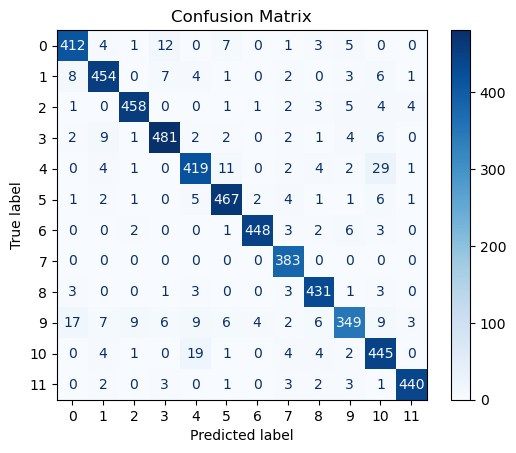

In [27]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




In [28]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=labels))
# Map for labels
print("Label mapping:", {idx: label for label, idx in enumerate(labels)})

Classification Report:
               precision    recall  f1-score   support

        down       0.93      0.93      0.93       445
          go       0.93      0.93      0.93       486
        left       0.97      0.96      0.96       479
          no       0.94      0.94      0.94       510
         off       0.91      0.89      0.90       473
          on       0.94      0.95      0.94       491
       right       0.98      0.96      0.97       465
     silence       0.93      1.00      0.96       383
        stop       0.94      0.97      0.96       445
     unknown       0.92      0.82      0.86       427
          up       0.87      0.93      0.90       480
         yes       0.98      0.97      0.97       455

    accuracy                           0.94      5539
   macro avg       0.94      0.94      0.94      5539
weighted avg       0.94      0.94      0.94      5539

Label mapping: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'silence': 7, 'stop': 